In [1]:
import torch
import triton
import triton.language as tl

In [2]:
@triton.jit
def get_1d_offset(size, n_prev_chunks):
    return n_prev_chunks * size + tl.arange(0, size)

@triton.jit
def get_2d_offset(offs_0, offs_1, stride_0, stride_1=1):
    return tl.expand_dims(offs_0, 1) * stride_0 + tl.expand_dims(offs_1, 0) * stride_1

@triton.jit
def get_1d_mask(offs, max):
    return offs < max

@triton.jit
def get_2d_mask(offs_0, offs_1, max_0, max_1):
    return (tl.expand_dims(offs_0, 1) < max_0 ) & (tl.expand_dims(offs_1, 0) < max_1)

def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]

In [3]:
# Let's add a bias to compute the output of a linear layer
@triton.autotune(
        configs=get_cuda_autotune_config(),
        key=['M', 'N', 'K']
)
@triton.jit
def nested_linear_expand_kernel(
    x_ptr,
    w_ptr,
    o_ptr,
    b_ptr,
    mask_ptr,
    M,
    N,
    K,
    E,
    stride_xm,
    stride_xk,
    stride_wk,
    stride_wn,
    stride_om,
    stride_on,
    stride_bias,
    stride_mask,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    # get swizzled program ids
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    # get offsets for each axis
    rm = get_1d_offset(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offset(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offset(BLOCK_SIZE_K, 0) # K will always start from 0

    # token mask only operates on the m dimension
    tmask = tl.load(mask_ptr + rm * stride_mask)
    tmask = tl.expand_dims(tmask, 1)

    # initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for e_i in range(E): # e is the number of experts
        # Get in_dim // 2^(e - e_i)
        k_i = K >> (E - e_i - 1)

        # relevant offsets for a and b
        # needs to be updated for each expert
        offs_x = x_ptr + get_2d_offset(rm, rk, stride_xm, stride_xk)
        offs_w = w_ptr + get_2d_offset(rk, rn, stride_wk, stride_wn)
        
        # get masks for the current expert
        t_mask_i = (tmask == (e_i))
        x_mask_i = get_2d_mask(rm, rk, M, k_i)
        w_mask_i = get_2d_mask(rk, rn, k_i, N)

        # perform dot product for the current expert dimension
        for _ in range(0, k_i, BLOCK_SIZE_K):
            x = tl.load(offs_x, mask=t_mask_i & x_mask_i, other=0.0)
            w = tl.load(offs_w, mask=w_mask_i, other=0.0)
            acc += tl.dot(x, w)

            # update offsets for next iteration
            offs_x += BLOCK_SIZE_K * stride_xk
            offs_w += BLOCK_SIZE_K * stride_wk

    # Add bias after accumulation
    if b_ptr is not None:
        offs_b = b_ptr + rn * stride_bias
        b_mask = rn < N
        b = tl.load(offs_b, mask=b_mask, other=0.0)
        acc += b[None, :]

    o = o_ptr + get_2d_offset(rm, rn, stride_om, stride_on)
    mask = get_2d_mask(rm, rn, M, N)
    tl.store(o, acc, mask=mask)

In [4]:
def nested_linear_expand(x, w, mask, b=None, experts=4):
    assert x.shape[1] == w.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "Matrix x must be contiguous"
    M, K = x.shape
    K, N = w.shape
    # Allocate output
    output = torch.empty((M, N), device=x.device, dtype=x.dtype)
    # 1D launch kernel where each block gets its own program
    grid = lambda meta: (
        triton.cdiv(M, meta["BLOCK_SIZE_M"]),
        triton.cdiv(N, meta["BLOCK_SIZE_N"]),
    )
    nested_linear_expand_kernel[grid](
        x,
        w,
        output,
        b,
        mask,
        M,
        N,
        K,
        experts,
        x.stride(0),
        x.stride(1),
        w.stride(0),
        w.stride(1),
        output.stride(0),
        output.stride(1),
        b.stride(0) if b is not None else None,
        mask.stride(0),
    )
    return output

In [5]:
# Test nested_linear_expand while keeping the mask fixed
x_expand = torch.ones((5, 128), device="cuda", dtype=torch.float16, requires_grad=True)
w_expand = torch.ones((128, 256), device="cuda", dtype=torch.float16, requires_grad=True)
bias_expand = torch.zeros((256), device="cuda", dtype=torch.float16, requires_grad=True)
mask_expand = torch.tensor([2, 3, 3, 0, 0], dtype=torch.int32, device="cuda")
output_expand = nested_linear_expand(x_expand, w_expand, mask_expand, bias_expand, experts=4)
print(output_expand)
print(output_expand.shape)

tensor([[ 64.,  64.,  64.,  ...,  64.,  64.,  64.],
        [128., 128., 128.,  ..., 128., 128., 128.],
        [128., 128., 128.,  ..., 128., 128., 128.],
        [ 16.,  16.,  16.,  ...,  16.,  16.,  16.],
        [ 16.,  16.,  16.,  ...,  16.,  16.,  16.]], device='cuda:0',
       dtype=torch.float16)
torch.Size([5, 256])


In [6]:
from layers import nested_linear_expand as nested_linear_expand_native

output_expand_native = nested_linear_expand_native(x_expand.view(1, 5, 128), w_expand.T, mask_expand.view(1, 5),bias_expand, num_experts=4)
print(output_expand_native)
print(output_expand_native.shape)

# get gradients
loss = output_expand_native.sum()
loss.backward()
# print(x_expand.grad)
# print(x_expand.grad.shape)
print(w_expand.grad)
print(w_expand.grad.shape)



/home/mikuk84/Development/mone-pytorch/mone_pytorch/layers.py:19: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")


tensor([[[ 64.,  64.,  64.,  ...,  64.,  64.,  64.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [ 16.,  16.,  16.,  ...,  16.,  16.,  16.],
         [ 16.,  16.,  16.,  ...,  16.,  16.,  16.]]], device='cuda:0',
       dtype=torch.float16, grad_fn=<ViewBackward0>)
torch.Size([1, 5, 256])
tensor([[5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]], device='cuda:0', dtype=torch.float16)
torch.Size([128, 256])


In [7]:
# Let's build the nested linear contraction
@triton.autotune(
        configs=get_cuda_autotune_config(),
        key=['M', 'N', 'K']
)
@triton.jit
def nested_linear_contract_kernel(
    x_ptr,
    w_ptr,
    o_ptr,
    b_ptr,
    mask_ptr,
    M,
    N,
    K,
    E,
    stride_xm,
    stride_xk,
    stride_wk,
    stride_wn,
    stride_om,
    stride_on,
    stride_bias,
    stride_mask,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    # get swizzled program ids
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    # get offsets for each axis
    rm = get_1d_offset(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offset(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offset(BLOCK_SIZE_K, 0) # K will always start from 0

    # token mask only operates on the m dimension
    tmask = tl.load(mask_ptr + rm * stride_mask)
    tmask = tl.expand_dims(tmask, 1)

    # mask for the current expert
    x_mask_i = get_2d_mask(rm, rk, M, K)

    # initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for e_i in range(E): # e is the number of experts
        # Get out_dim // 2^(e - e_i)
        n_i = N >> (E - e_i - 1)

        # relevant offsets for a and b
        # needs to be updated for each expert
        offs_x = x_ptr + get_2d_offset(rm, rk, stride_xm, stride_xk)
        offs_w = w_ptr + get_2d_offset(rk, rn, stride_wk, stride_wn)

        # get masks for the current expert
        t_mask_i = (tmask == (e_i))
        w_mask_i = get_2d_mask(rk, rn, K, n_i)

        for _ in range(0, K, BLOCK_SIZE_K):
            x = tl.load(offs_x, mask=t_mask_i & x_mask_i, other=0.0)
            w = tl.load(offs_w, mask=w_mask_i, other=0.0)
            acc += tl.dot(x, w)

            # update offsets for next iteration
            offs_x += BLOCK_SIZE_K * stride_xk
            offs_w += BLOCK_SIZE_K * stride_wk

    # Add bias after accumulation
    if b_ptr is not None:
        offs_b = b_ptr + rn * stride_bias
        b_mask = rn < N
        b = tl.load(offs_b, mask=b_mask, other=0.0)
        acc += b[None, :]

    o = o_ptr + get_2d_offset(rm, rn, stride_om, stride_on)
    mask = get_2d_mask(rm, rn, M, N)
    tl.store(o, acc, mask=mask)



In [8]:
def nested_linear_contract(x, w, mask, b=None, experts=4):
    assert x.shape[1] == w.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "Matrix x must be contiguous"
    M, K = x.shape
    K, N = w.shape
    # Allocate output
    output = torch.empty((M, N), device=x.device, dtype=x.dtype)
    # 1D launch kernel where each block gets its own program
    grid = lambda meta: (
        triton.cdiv(M, meta["BLOCK_SIZE_M"]),
        triton.cdiv(N, meta["BLOCK_SIZE_N"]),
    )
    nested_linear_contract_kernel[grid](
        x,
        w,
        output,
        b,
        mask,
        M,
        N,
        K,
        experts,
        x.stride(0),
        x.stride(1),
        w.stride(0),
        w.stride(1),
        output.stride(0),
        output.stride(1),
        b.stride(0) if b is not None else None,
        mask.stride(0),
    )
    return output

In [9]:
# Test nested_linear_contract while keeping the mask fixed
x_contract = torch.ones((5, 256), device="cuda", dtype=torch.float16, requires_grad=True)
w_contract = torch.ones((256, 128), device="cuda", dtype=torch.float16, requires_grad=True)
bias_contract = torch.zeros((128), device="cuda", dtype=torch.float16, requires_grad=True)
mask_contract = torch.tensor([2, 3, 3, 0, 0], dtype=torch.int32, device="cuda")
output_contract = nested_linear_contract(x_contract, w_contract, mask_contract, bias_contract, experts=4)
print(output_contract[:, :32])
print(output_contract.shape)

tensor([[256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256.,   0., 

In [10]:
from layers import nested_linear_contract as nested_linear_contract_native
output_contract_native = nested_linear_contract_native(x_contract.view(1, 5, 256), w_contract.T, mask_contract.view(1, 5), bias_contract, num_experts=4)
print(output_contract_native.view(-1, 128)[:, :32])
print(output_contract_native.shape)

# get gradients
loss = output_contract_native.sum()
loss.backward()
# print(x_contract.grad)
# print(x_contract.grad.shape)
print(w_contract.grad)
print(w_contract.grad.shape)



tensor([[256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256.,   0., 

In [11]:
# Let's add a bias to compute the output of a linear layer
@triton.autotune(
        configs=get_cuda_autotune_config(),
        key=['M', 'N', 'K']
)
@triton.jit
def nested_linear_expand_dx_kernel(
    dy_ptr,
    wT_ptr,
    dx_ptr,
    mask_ptr,
    M,
    N,
    K,
    E,
    stride_dym,
    stride_dyk,
    stride_wTk,
    stride_wTn,
    stride_dxm,
    stride_dxn,
    stride_mask,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    # get swizzled program ids
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    # get offsets for each axis
    rm = get_1d_offset(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offset(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offset(BLOCK_SIZE_K, 0) # K will always start from 0

    # token mask only operates on the m dimension
    tmask = tl.load(mask_ptr + rm * stride_mask)
    tmask = tl.expand_dims(tmask, 1)

    # initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for e_i in range(E): # e is the number of experts
        # Get in_dim // 2^(e - e_i)
        n_i = N >> (E - e_i - 1)

        # relevant offsets for a and b
        # needs to be updated for each expert
        offs_dy = dy_ptr + get_2d_offset(rm, rk, stride_dym, stride_dyk)
        offs_wT = wT_ptr + get_2d_offset(rk, rn, stride_wTk, stride_wTn)  
        
        # get masks for the current expert
        t_mask_i = (tmask == (e_i))
        dy_mask_i = get_2d_mask(rm, rk, M, K)
        wT_mask_i = get_2d_mask(rk, rn, K, n_i)

        # perform dot product for the current expert dimension
        for _ in range(0, K, BLOCK_SIZE_K):
            dy = tl.load(offs_dy, mask=t_mask_i & dy_mask_i, other=0.0)
            wT = tl.load(offs_wT, mask=wT_mask_i, other=0.0)
            acc += tl.dot(dy, wT)

            # update offsets for next iteration
            offs_dy += BLOCK_SIZE_K * stride_dyk
            offs_wT += BLOCK_SIZE_K * stride_wTn

    dx = dx_ptr + get_2d_offset(rm, rn, stride_dxm, stride_dxn)
    mask = get_2d_mask(rm, rn, M, N)
    tl.store(dx, acc, mask=mask)

In [12]:
def nested_linear_expand_dx(dy, wT, mask, experts=4):
    assert dy.shape[1] == wT.shape[0], "Incompatible dimensions"
    assert dy.is_contiguous(), "Matrix dy must be contiguous"
    M, K = dy.shape
    K, N = wT.shape
    # Allocate output
    dx = torch.empty((M, N), device=dy.device, dtype=dy.dtype)
    # 1D launch kernel where each block gets its own program
    grid = lambda meta: (
        triton.cdiv(M, meta["BLOCK_SIZE_M"]),
        triton.cdiv(N, meta["BLOCK_SIZE_N"]),
    )
    nested_linear_expand_dx_kernel[grid](
        dy,
        wT,
        dx,
        mask,
        M,
        N,
        K,
        experts,
        dy.stride(0),
        dy.stride(1),
        wT.stride(0),
        wT.stride(1),
        dx.stride(0),
        dx.stride(1),
        mask.stride(0),
    )
    return dx

In [13]:
# Test nested_linear_expand_dx while keeping the mask fixed
dy = torch.ones((5, 256), device="cuda", dtype=torch.float16, requires_grad=True)
wT = torch.ones((256, 128), device="cuda", dtype=torch.float16, requires_grad=True)
mask = torch.tensor([2, 3, 3, 0, 0], dtype=torch.int32, device="cuda")
output_expand_dx = nested_linear_expand_dx(dy, wT, mask, experts=4)
print(output_expand_dx)
print(output_expand_dx.shape)


tensor([[256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256., 256.,
         256., 256., 256., 256., 256., 256., 256., 

In [14]:
# Let's add a bias to compute the output of a linear layer
@triton.autotune(
        configs=get_cuda_autotune_config(),
        key=['M', 'N', 'K']
)
@triton.jit
def nested_linear_expand_dw_kernel(
    dyT_ptr,
    x_ptr,
    dw_ptr,
    mask_ptr,
    dbias_ptr,
    M,
    N,
    K,
    E,
    stride_dyTm,
    stride_dyTk,
    stride_xk,
    stride_xn,
    stride_dwm,
    stride_dwn,
    stride_mask,
    stride_bias,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    # get swizzled program ids
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    # get offsets for each axis
    rm = get_1d_offset(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offset(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offset(BLOCK_SIZE_K, 0) # K will always start from 0

    # token mask only operates on the k dimension
    tmask = tl.load(mask_ptr + rk * stride_mask)

    # initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    if dbias_ptr is not None:
        acc_bias = tl.zeros((BLOCK_SIZE_M, ), dtype=tl.float32)
    for e_i in range(E): # e is the number of experts
        # Get out_dim // 2^(e - e_i)
        n_i = N >> (E - e_i - 1)

        # relevant offsets for a and b
        # needs to be updated for each expert
        offs_dyT = dyT_ptr + get_2d_offset(rm, rk, stride_dyTm, stride_dyTk)
        offs_x = x_ptr + get_2d_offset(rk, rn, stride_xk, stride_xn)
        
        # get masks for the current expert
        t_mask_i = (tmask == (e_i))
        dyT_mask_i = get_2d_mask(rm, rk, M, K)
        x_mask_i = get_2d_mask(rk, rn, K, n_i)

        # perform dot product for the current expert dimension
        for _ in range(0, K, BLOCK_SIZE_K):
            dyT = tl.load(offs_dyT, mask=tl.expand_dims(t_mask_i, 0) & dyT_mask_i, other=0.0)
            x = tl.load(offs_x, mask=tl.expand_dims(t_mask_i, 1) & x_mask_i, other=0.0)
            acc += tl.dot(dyT, x)
            if dbias_ptr is not None:
                acc_bias += tl.sum(dyT, axis=1)

            # update offsets for next iteration
            offs_dyT += BLOCK_SIZE_K * stride_dyTk
            offs_x += BLOCK_SIZE_K * stride_xn

    if dbias_ptr is not None:
        offs_dbias = dbias_ptr + rm * stride_bias
        dbias_mask = rm < M
        tl.store(offs_dbias, acc_bias, mask=dbias_mask)

    dw = dw_ptr + get_2d_offset(rm, rn, stride_dwm, stride_dwn)
    mask = get_2d_mask(rm, rn, M, N)
    tl.store(dw, acc, mask=mask)

In [15]:
def nested_linear_expand_dw(dyT, x, mask, bias=False, experts=4):
    assert dyT.shape[1] == x.shape[0], "Incompatible dimensions"
    assert dyT.is_contiguous(), "Matrix dyT must be contiguous"
    M, K = dyT.shape
    K, N = x.shape
    # Allocate output
    dw = torch.empty((M, N), device=dyT.device, dtype=dyT.dtype)
    dbias = None
    if bias:
        dbias = torch.empty((M,), device=dyT.device, dtype=dyT.dtype)
    grid = lambda meta: (
        triton.cdiv(M, meta["BLOCK_SIZE_M"]),
        triton.cdiv(N, meta["BLOCK_SIZE_N"]),
    )
    nested_linear_expand_dw_kernel[grid](
        dyT,
        x,
        dw,
        mask,
        dbias,
        M,
        N,
        K,
        experts,
        dyT.stride(0),
        dyT.stride(1),
        x.stride(0),
        x.stride(1),
        dw.stride(0),
        dw.stride(1),
        mask.stride(0),
        dbias.stride(0) if bias else None,
    )
    return dw, dbias

In [16]:
# Test nested_linear_contract_dx while keeping the mask fixed
dyT = torch.ones((256, 5), device="cuda", dtype=torch.float16, requires_grad=True)
x = torch.ones((5, 128), device="cuda", dtype=torch.float16, requires_grad=True)
mask = torch.tensor([2, 3, 3, 0, 0], dtype=torch.int32, device="cuda")
dw, dbias = nested_linear_expand_dw(dyT, x, mask, bias=False, experts=4)
print(dw.T)
print(dbias)
print(dw.shape)
if dbias is not None:
    print(dbias.shape)

tensor([[5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]], device='cuda:0', dtype=torch.float16)
None
torch.Size([256, 128])


In [17]:
# Let's add a bias to compute the output of a linear layer
@triton.autotune(
        configs=get_cuda_autotune_config(),
        key=['M', 'N', 'K']
)
@triton.jit
def nested_linear_contract_dx_kernel(
    dy_ptr,
    wT_ptr,
    dx_ptr,
    mask_ptr,
    M,
    N,
    K,
    E,
    stride_dym,
    stride_dyk,
    stride_wTk,
    stride_wTn,
    stride_dxm,
    stride_dxn,
    stride_mask,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    # get swizzled program ids
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    # get offsets for each axis
    rm = get_1d_offset(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offset(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offset(BLOCK_SIZE_K, 0) # K will always start from 0

    # token mask only operates on the m dimension
    tmask = tl.load(mask_ptr + rm * stride_mask)
    tmask = tl.expand_dims(tmask, 1)

    # initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    
    for e_i in range(E): # e is the number of experts
        # Get in_dim // 2^(e - e_i)
        k_i = K >> (E - e_i - 1)

        # relevant offsets for a and b
        # needs to be updated for each expert
        offs_dy = dy_ptr + get_2d_offset(rm, rk, stride_dym, stride_dyk)
        offs_wT = wT_ptr + get_2d_offset(rk, rn, stride_wTk, stride_wTn)
        
        # get masks for the current expert
        t_mask_i = (tmask == (e_i))
        dy_mask_i = get_2d_mask(rm, rk, M, k_i)
        wT_mask_i = get_2d_mask(rk, rn, k_i, N)

        # perform dot product for the current expert dimension
        for _ in range(0, k_i, BLOCK_SIZE_K):
            dy = tl.load(offs_dy, mask=t_mask_i & dy_mask_i, other=0.0)
            wT = tl.load(offs_wT, mask=wT_mask_i, other=0.0)
            acc += tl.dot(dy, wT)

            # update offsets for next iteration
            offs_dy += BLOCK_SIZE_K * stride_dyk
            offs_wT += BLOCK_SIZE_K * stride_wTn

    dx = dx_ptr + get_2d_offset(rm, rn, stride_dxm, stride_dxn)
    mask = get_2d_mask(rm, rn, M, N)
    tl.store(dx, acc, mask=mask)

In [18]:
def nested_linear_contract_dx(dy, wT, mask, experts=4):
    assert dy.shape[1] == wT.shape[0], "Incompatible dimensions"
    assert dy.is_contiguous(), "Matrix dy must be contiguous"
    M, N = dy.shape
    K, N = wT.shape
    # Allocate output
    dx = torch.empty((M, N), device=dy.device, dtype=dy.dtype)
    grid = lambda meta: (
        triton.cdiv(M, meta["BLOCK_SIZE_M"]),
        triton.cdiv(N, meta["BLOCK_SIZE_N"]),
    )
    nested_linear_contract_dx_kernel[grid](
        dy,
        wT,
        dx,
        mask,
        M,
        N,
        K,
        experts,
        dy.stride(0),
        dy.stride(1),
        wT.stride(0),
        wT.stride(1),
        dx.stride(0),
        dx.stride(1),
        mask.stride(0),
    )
    return dx

In [19]:
# Test nested_linear_contract_dx while keeping the mask fixed
dy = torch.ones((5, 128), device="cuda", dtype=torch.float16, requires_grad=True)
wT = torch.ones((128, 256), device="cuda", dtype=torch.float16, requires_grad=True)
mask = torch.tensor([2, 3, 3, 0, 0], dtype=torch.int32, device="cuda")
output = nested_linear_contract_dx(dy, wT, mask, experts=4)
print(output)
print(output.shape)

tensor([[ 64.,  64.,  64.,  ...,  64.,  64.,  64.],
        [128., 128., 128.,  ..., 128., 128., 128.],
        [128., 128., 128.,  ..., 128., 128., 128.],
        [ 16.,  16.,  16.,  ...,  16.,  16.,  16.],
        [ 16.,  16.,  16.,  ...,  16.,  16.,  16.]], device='cuda:0',
       dtype=torch.float16)
torch.Size([5, 256])


In [20]:
# Let's add a bias to compute the output of a linear layer
@triton.autotune(
        configs=get_cuda_autotune_config(),
        key=['M', 'N', 'K']
)
@triton.jit
def nested_linear_contract_dw_kernel(
    dyT_ptr,
    x_ptr,
    dw_ptr,
    mask_ptr,
    dbias_ptr,
    M,
    N,
    K,
    E,
    stride_dyTm,
    stride_dyTk,
    stride_xk,
    stride_xn,
    stride_dwm,
    stride_dwn,
    stride_mask,
    stride_bias,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    # get swizzled program ids
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    # get offsets for each axis
    rm = get_1d_offset(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offset(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offset(BLOCK_SIZE_K, 0) # K will always start from 0

    # token mask only operates on the k dimension
    tmask = tl.load(mask_ptr + rk * stride_mask)

    # initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    acc_bias = tl.zeros((BLOCK_SIZE_M, ), dtype=tl.float32)
    for e_i in range(E): # e is the number of experts
        # Get out_dim // 2^(e - e_i)
        m_i = M >> (E - e_i - 1)

        # relevant offsets for a and b
        # needs to be updated for each expert
        offs_dyT = dyT_ptr + get_2d_offset(rm, rk, stride_dyTm, stride_dyTk)
        offs_x = x_ptr + get_2d_offset(rk, rn, stride_xk, stride_xn)
        
        # get masks for the current expert
        t_mask_i = (tmask == (e_i))
        dyT_mask_i = get_2d_mask(rm, rk, m_i, K)
        x_mask_i = get_2d_mask(rk, rn, K, N)

        # perform dot product for the current expert dimension
        for _ in range(0, K, BLOCK_SIZE_K):
            dyT = tl.load(offs_dyT, mask=tl.expand_dims(t_mask_i, 0) & dyT_mask_i, other=0.0)
            x = tl.load(offs_x, mask=tl.expand_dims(t_mask_i, 1) & x_mask_i, other=0.0)
            acc += tl.dot(dyT, x)
            if dbias_ptr is not None:
                acc_bias += tl.sum(dyT, axis=1)

            # update offsets for next iteration
            offs_dyT += BLOCK_SIZE_K * stride_dyTk
            offs_x += BLOCK_SIZE_K * stride_xn

    if dbias_ptr is not None:
        offs_dbias = dbias_ptr + rm * stride_bias
        dbias_mask = rm < M
        tl.store(offs_dbias, acc_bias, mask=dbias_mask)

    dw = dw_ptr + get_2d_offset(rm, rn, stride_dwm, stride_dwn)
    mask = get_2d_mask(rm, rn, M, N)
    tl.store(dw, acc, mask=mask)

In [21]:
def nested_linear_contract_dw(dyT, x, mask, bias=False, experts=4):
    assert dyT.shape[1] == x.shape[0], "Incompatible dimensions"
    assert dyT.is_contiguous(), "Matrix dyT must be contiguous"
    M, N = dyT.shape
    K, N = x.shape
    # Allocate output
    dw = torch.empty((M, N), device=dyT.device, dtype=dyT.dtype)
    dbias = None
    if bias:
        dbias = torch.empty((M,), device=dyT.device, dtype=dyT.dtype)
    grid = lambda meta: (
        triton.cdiv(M, meta["BLOCK_SIZE_M"]),
        triton.cdiv(N, meta["BLOCK_SIZE_N"]),
    )
    nested_linear_contract_dw_kernel[grid](
        dyT,
        x,
        dw,
        mask,
        dbias,
        M,
        N,
        K,
        experts,
        dyT.stride(0),
        dyT.stride(1),
        x.stride(0),
        x.stride(1),
        dw.stride(0),
        dw.stride(1),
        mask.stride(0),
        dbias.stride(0) if bias else None,
    )
    return dw, dbias

In [22]:
# Test nested_linear_contract_dw while keeping the mask fixed
dyT = torch.ones((256, 5), device="cuda", dtype=torch.float16, requires_grad=True)
x = torch.ones((5, 128), device="cuda", dtype=torch.float16, requires_grad=True)
mask = torch.tensor([2, 3, 3, 0, 0], dtype=torch.int32, device="cuda")
dW, dbias = nested_linear_contract_dw(dyT, x, mask, bias=False, experts=4)
print(dW)
print(dW.shape)
if dbias is not None:
    print(dbias)



tensor([[5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        [5., 5., 5.,  ..., 5., 5., 5.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]], device='cuda:0', dtype=torch.float16)
torch.Size([256, 128])


In [23]:
class NestedLinearExpand(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, w, mask, bias=None, experts=4):
        ctx.experts = experts
        ctx.bias = False if bias is None else True
        ctx.save_for_backward(x, w, mask)
        return nested_linear_expand(x, w.transpose(0, 1), mask, bias, experts)

    @staticmethod
    def backward(ctx, grad_output):
        x, w, mask = ctx.saved_tensors
        experts = ctx.experts
        bias = ctx.bias
        dx = nested_linear_expand_dx(grad_output, w, mask, experts=experts)
        dw, dbias = nested_linear_expand_dw(
            grad_output.transpose(0, 1), x, mask, bias=bias, experts=experts
        )
        return dx, dw, None, dbias, None

In [24]:
class NestedLinearContract(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, w, mask, bias=None, experts=4):
        ctx.experts = experts
        ctx.bias = False if bias is None else True
        ctx.save_for_backward(x, w, mask)
        return nested_linear_contract(x, w.transpose(0, 1), mask, bias, experts)

    @staticmethod
    def backward(ctx, grad_output):
        x, w, mask = ctx.saved_tensors
        experts = ctx.experts
        bias = ctx.bias
        dy = nested_linear_contract_dx(grad_output, w, mask, experts=experts)
        dw, dbias = nested_linear_contract_dw(
            grad_output.transpose(0, 1), x, mask, bias=bias, experts=experts
        )
        return dy, dw, None, dbias, None

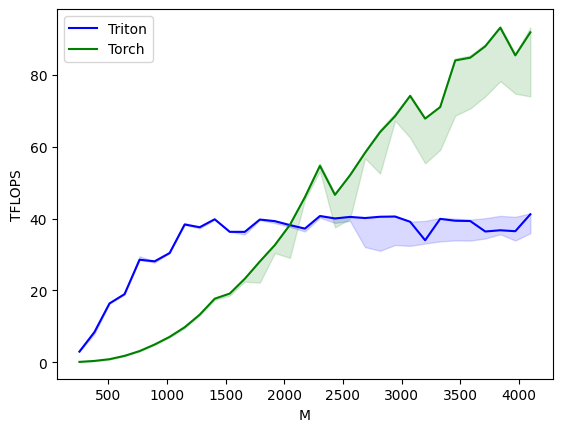

nested_linear_expand_perf:
         M       N       K     Triton      Torch
0    256.0   256.0   256.0   2.978909   0.116573
1    384.0   384.0   384.0   8.426057   0.388000
2    512.0   512.0   512.0  16.384000   0.865162
3    640.0   640.0   640.0  18.962963   1.795999
4    768.0   768.0   768.0  28.539871   3.123516
5    896.0   896.0   896.0  28.098561   4.946385
6   1024.0  1024.0  1024.0  30.393507   7.084973
7   1152.0  1152.0  1152.0  38.343292   9.758118
8   1280.0  1280.0  1280.0  37.577981  13.248964
9   1408.0  1408.0  1408.0  39.793987  17.698776
10  1536.0  1536.0  1536.0  36.296861  19.124582
11  1664.0  1664.0  1664.0  36.285936  23.226745
12  1792.0  1792.0  1792.0  39.715279  28.027397
13  1920.0  1920.0  1920.0  39.272727  32.603774
14  2048.0  2048.0  2048.0  38.173415  38.214172
15  2176.0  2176.0  2176.0  37.197132  45.944403
16  2304.0  2304.0  2304.0  40.694842  54.663321
17  2432.0  2432.0  2432.0  40.020605  46.591151
18  2560.0  2560.0  2560.0  40.454321  52.

In [25]:


config=triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 33)],
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="TFLOPS",
        plot_name="nested_linear_expand_perf",
        args={}
    )
@triton.testing.perf_report(config)
def benchmark(M, N, K, provider):
    x = torch.randn((M, K), device="cuda", dtype=torch.float16)
    w = torch.randn((N, K), device="cuda", dtype=torch.float16)
    mask = torch.randint(0, 4, (M,), device="cuda", dtype=torch.int32)
    quantiles = [0.5, 0.2, 0.8]
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    if provider == "triton":
        w_ = w.T.contiguous()
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: nested_linear_expand(x, w_, mask, b=None, experts=4), quantiles=quantiles)
    else:
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: nested_linear_expand_native(x, w, mask, b=None, num_experts=4), quantiles=quantiles)
    return perf(ms), perf(min_ms), perf(max_ms)

benchmark.run(show_plots=True, print_data=True)


In [27]:
from typing import Optional
import torch
import torch.nn.functional as F
import triton

def nested_linear_expand(
    x: torch.Tensor,
    w: torch.Tensor,
    token_mask: torch.Tensor,
    b: Optional[torch.Tensor] = None,
    num_experts: int = 4,
) -> torch.Tensor:
    input_shape = x.shape
    in_dim = x.shape[-1]
    batch_seq = x.shape[:-1].numel()
    out_dim = w.shape[0]
    output = torch.zeros((batch_seq, out_dim), device=x.device, dtype=x.dtype)
    x = x.reshape(batch_seq, in_dim)
    for m in range(num_experts):
        # get the valid mask for the m-th expert
        valid_mask = (token_mask == m).view(batch_seq)
        # N_m = valid_mask.sum().item()

        # skip if no tokens are assigned to the m-th expert
        # if N_m == 0:
        #     continue

        D_m = in_dim >> (num_experts - m - 1)

        # slice the input and weight
        x_m = x[valid_mask, :D_m]
        w_m = w[:, :D_m]

        # project up to the expert dim
        output[valid_mask, :] = F.linear(x_m, w_m, b)

    return output.reshape(input_shape[:-1] + (out_dim,))

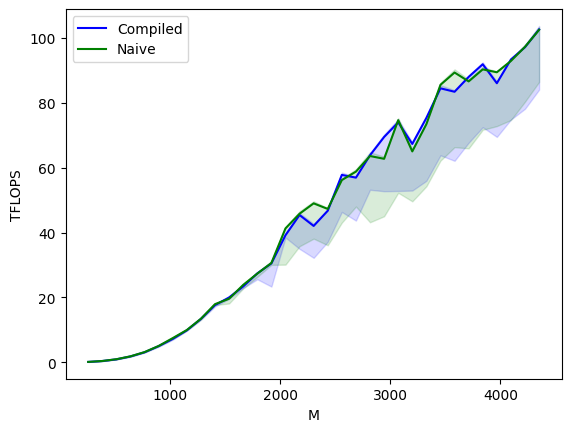

nested_linear_expand_perf:
         M       N       K    Compiled       Naive
0    256.0   256.0   256.0    0.112605    0.115788
1    384.0   384.0   384.0    0.387702    0.397634
2    512.0   512.0   512.0    0.907073    0.941800
3    640.0   640.0   640.0    1.806992    1.834817
4    768.0   768.0   768.0    3.082704    3.148177
5    896.0   896.0   896.0    4.982014    5.035584
6   1024.0  1024.0  1024.0    7.206708    7.458198
7   1152.0  1152.0  1152.0    9.854732    9.953280
8   1280.0  1280.0  1280.0   13.385621   13.429508
9   1408.0  1408.0  1408.0   17.638828   17.933474
10  1536.0  1536.0  1536.0   19.999331   19.606337
11  1664.0  1664.0  1664.0   23.394686   23.869794
12  1792.0  1792.0  1792.0   27.413229   27.347569
13  1920.0  1920.0  1920.0   30.487112   30.628540
14  2048.0  2048.0  2048.0   39.187658   41.291411
15  2176.0  2176.0  2176.0   45.425842   45.823435
16  2304.0  2304.0  2304.0   42.056111   49.022761
17  2432.0  2432.0  2432.0   46.742554   47.299563
18  

In [28]:
compiled_linear = torch.compile(nested_linear_expand)
naive_linear = nested_linear_expand

config=triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 35)],
        line_arg="provider",
        line_vals=["compiled", "naive"],
        line_names=["Compiled", "Naive"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="TFLOPS",
        plot_name="nested_linear_expand_perf",
        args={}
    )
@triton.testing.perf_report(config)
def benchmark(M, N, K, provider):
    x = torch.randn((M, K), device="cuda", dtype=torch.float16)
    w = torch.randn((N, K), device="cuda", dtype=torch.float16)
    mask = torch.randint(0, 4, (M,), device="cuda", dtype=torch.int32)
    quantiles = [0.5, 0.2, 0.8]
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    if provider == "compiled":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: compiled_linear(x, w, mask, b=None, num_experts=4), quantiles=quantiles)
    else:
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_linear(x, w, mask, b=None, num_experts=4), quantiles=quantiles)
    return perf(ms), perf(min_ms), perf(max_ms)

benchmark.run(show_plots=True, print_data=True)

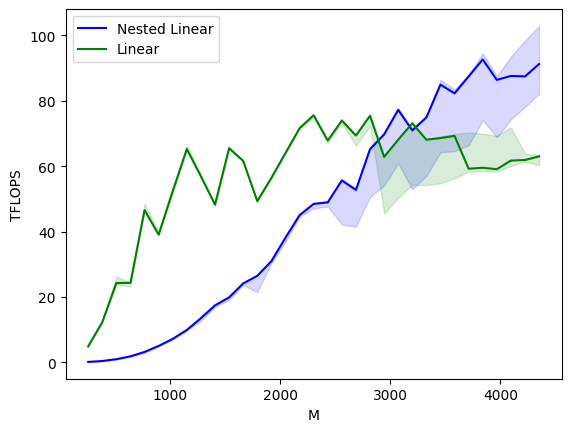

nested_linear_vs_linear_perf:
         M       N       K  Nested Linear     Linear
0    256.0   256.0   256.0       0.113347   4.877098
1    384.0   384.0   384.0       0.389408  12.288000
2    512.0   512.0   512.0       0.942964  24.244533
3    640.0   640.0   640.0       1.821861  24.308605
4    768.0   768.0   768.0       3.171097  46.565055
5    896.0   896.0   896.0       4.999744  39.025776
6   1024.0  1024.0  1024.0       7.157516  52.428801
7   1152.0  1152.0  1152.0       9.887364  65.245128
8   1280.0  1280.0  1280.0      13.505616  56.888887
9   1408.0  1408.0  1408.0      17.407386  48.245805
10  1536.0  1536.0  1536.0      19.867755  65.536000
11  1664.0  1664.0  1664.0      24.125770  61.636381
12  1792.0  1792.0  1792.0      26.445703  49.295718
13  1920.0  1920.0  1920.0      30.924012  56.424489
14  2048.0  2048.0  2048.0      38.130036  64.035179
15  2176.0  2176.0  2176.0      45.019347  71.614409
16  2304.0  2304.0  2304.0      48.454099  75.594534
17  2432.0  2432

In [30]:
# Now let's test the nested layer against pytorch's linear layer
config=triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 35)],
        line_arg="provider",
        line_vals=["nested_linear", "linear"],
        line_names=["Nested Linear", "Linear"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="TFLOPS",
        plot_name="nested_linear_vs_linear_perf",
        args={}
    )
@triton.testing.perf_report(config)
def benchmark(M, N, K, provider):
    x = torch.randn((M, K), device="cuda", dtype=torch.float16)
    w = torch.randn((N, K), device="cuda", dtype=torch.float16)
    mask = torch.randint(0, 4, (M,), device="cuda", dtype=torch.int32)
    quantiles = [0.5, 0.2, 0.8]
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    if provider == "nested_linear":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: nested_linear_expand(x, w, mask, b=None, num_experts=4), quantiles=quantiles)
    else:
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: F.linear(x, w), quantiles=quantiles)
    return perf(ms), perf(min_ms), perf(max_ms)

benchmark.run(show_plots=True, print_data=True)